# Time Series

For: POH JIA JUN

The idea for this file is to train time series models given the dataset. The data files you will need to import is unfortunately not ready. But for now, write and test the code using `model_building_data.csv` which is provided in the data folder. Keep in mind that the final training/testing files will have more fields.

Compared to other files, I know the least about time series so I cant give you many tips. Good Luck lol. At least try out ARiMA and GARCH. There are obviously other stuff to play around with so stay creative.

Different models will likely have a different preprocessing step so do that accordingly.

Last thing to keep in mind is, some rows might have missing revenue but non-missing CAR etc. If you will drop NaNs, drop for each y values differently to prevent unnecessary data loss.

Tune all parameters using 3-fold CV with the timesplit function like in assignment 1. I'll write a different time split function and we'll rerun with 5-10 fold CV again later before submission.

This file should save the output of the prediction in the format:

| ticker | quarter_year  | log_revenue_prediction | CAR_prediction |
|--------|---------------|------------------------|----------------|
| BAC    | Q1 2001       | 123                    | 0.5            |
| JPM    | Q1 2001       | 456                    | 0.8            |
| WFC    | Q1 2001       | 789                    | 0.25           |

Enjoy and good luck lol!

In [1]:
# ===========================
# 1. Imports
# ===========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

In [2]:
# ===========================
# 2. Load Data
# ===========================
df_rev = pd.read_csv('data/train_data_REV_with_text.csv')
df_rev['quarter'] = pd.to_datetime(df_rev['datacqtr'].str[:4] + '-' + df_rev['datacqtr'].str[5:].astype(int).mul(3).astype(str) + '-01')
df_rev['quarter_year'] = df_rev['datacqtr'].str.replace('Q', ' Q')
df_rev = df_rev.sort_values(['tic', 'quarter'])

In [3]:
# ===========================
# 3. ARIMA Forecasting per Ticker
# ===========================
forecast_rows = []
for tic in df_rev['tic'].unique():
    dft = df_rev[df_rev['tic'] == tic].sort_values('quarter')
    train = dft.iloc[:int(0.8 * len(dft))]
    test = dft.iloc[int(0.8 * len(dft)):]
    if len(train) < 8 or test.empty:
        continue
    try:
        model = ARIMA(train['Total Current Operating Revenue'], order=(1,1,1)).fit()
        pred = model.forecast(steps=len(test))
        for i, (_, row) in enumerate(test.iterrows()):
            forecast_rows.append({
                'tic': tic,
                'quarter_year': row['datacqtr'].replace('Q', ' Q'),
                'y_true_rev': row['Total Current Operating Revenue'],
                'y_pred_rev': pred.iloc[i]
            })
    except:
        continue

df_arima_result = pd.DataFrame(forecast_rows)

In [4]:
# ===========================
# 4. LSTM for CAR (BERT)
# ===========================
df_car = pd.read_csv('data/train_data_CAR5_with_text.csv')
df_car['quarter'] = pd.to_datetime(df_car['datacqtr'].str[:4] + '-' + df_car['datacqtr'].str[5:].astype(int).mul(3).astype(str) + '-01')
df_car['CAR_class'] = (df_car['car5'] > 0).astype(int)
df_car = df_car.sort_values(['quarter'])

macro_feats = [
    'Net Interest Margin', 'Net Interest Income',
    'GDP CHANGE (-1 to 1)', 'UNEMPLOYMENT RATE (0 to 1)',
    'PRIME LOAN RATE (0 to 1)', 'DEPOSITS CHANGE (-1 to 1)',
    'CONSUMER PRICE INDEX (0 to 1)'
]

for col in macro_feats + ['bert_reviews_score']:
    for lag in range(1, 4):
        df_car[f'{col}_lag{lag}'] = df_car.groupby('tic')[col].shift(lag)

lagged_cols = [f"{col}_lag{lag}" for col in macro_feats + ['bert_reviews_score'] for lag in range(1, 4)]
df_car = df_car.dropna(subset=lagged_cols + ['CAR_class'])

# Fixed 80/20 time-based split
cutoff_index = int(len(df_car) * 0.8)
cutoff_date = df_car.iloc[cutoff_index]['quarter']
train_df = df_car[df_car['quarter'] < cutoff_date]
test_df = df_car[df_car['quarter'] >= cutoff_date]

feature_names = macro_feats + ['bert_reviews_score']
X_train = np.stack([train_df[[f"{feat}_lag1", f"{feat}_lag2", f"{feat}_lag3"]].values for feat in feature_names], axis=2)
X_test = np.stack([test_df[[f"{feat}_lag1", f"{feat}_lag2", f"{feat}_lag3"]].values for feat in feature_names], axis=2)
y_train = train_df['CAR_class'].values
y_test = test_df['CAR_class'].values

model = Sequential()
model.add(LSTM(32, input_shape=(3, len(feature_names)), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stop], verbose=0)

y_pred_prob = model.predict(X_test).flatten()
y_pred_cls = (y_pred_prob >= 0.5).astype(int)

roc_auc = roc_auc_score(y_test, y_pred_prob)
pr_auc = average_precision_score(y_test, y_pred_prob)

print("► CAR Classification (LSTM with BERT sentiment - Time-based Split)")
print(f"ROC-AUC: {roc_auc:.4f}, PR-AUC: {pr_auc:.4f}")
print(classification_report(y_test, y_pred_cls))

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
► CAR Classification (LSTM with BERT sentiment - Time-based Split)
ROC-AUC: 0.4796, PR-AUC: 0.5539
              precision    recall  f1-score   support

           0       0.59      0.02      0.04       678
           1       0.56      0.99      0.71       854

    accuracy                           0.56      1532
   macro avg       0.58      0.50      0.38      1532
weighted avg       0.57      0.56      0.41      1532



In [5]:
# ===========================
# 5. Revenue Forecast Evaluation
# ===========================
merged = df_arima_result.dropna()
y_true = merged['y_true_rev']
y_pred = merged['y_pred_rev']

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("► Revenue Forecasting Metrics")
print(f"MSE : {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")

► Revenue Forecasting Metrics
MSE : 0.0006
RMSE: 0.0242
MAE : 0.0173
R²  : 0.9791


In [ ]:
# ===========================
# 6. Prediction output
# ===========================
car_forecast_rows = []
for tic in df_car['tic'].unique():
    dft = df_car[df_car['tic'] == tic].sort_values('quarter')
    train = dft.iloc[:int(0.8 * len(dft))]
    test = dft.iloc[int(0.8 * len(dft)):]
    if len(train) < 8 or test.empty:
        continue
    try:
        model = ARIMA(train['car5'], order=(1,1,1)).fit()
        pred = model.forecast(steps=len(test))
        for i, (_, row) in enumerate(test.iterrows()):
            car_forecast_rows.append({
                'tic': tic,
                'quarter_year': row['datacqtr'].replace('Q', ' Q'),
                'CAR_prediction': pred.iloc[i]
            })
    except:
        continue

df_car_result = pd.DataFrame(car_forecast_rows)

df_merge = df_arima_result.merge(df_car_result, on=['tic', 'quarter_year'], how='outer')
df_merge['log_revenue_prediction'] = np.log1p(df_merge['y_pred_rev'])
df_merge.rename(columns={'tic': 'ticker'}, inplace=True)

final_df = df_merge[['ticker', 'quarter_year', 'log_revenue_prediction', 'CAR_prediction']]
final_df.to_csv('ts_predictions.csv', index=False)
print("✅ Final file saved: ts_predictions.csv")

✅ Final file saved: ts_predictions_arima_full_series.csv


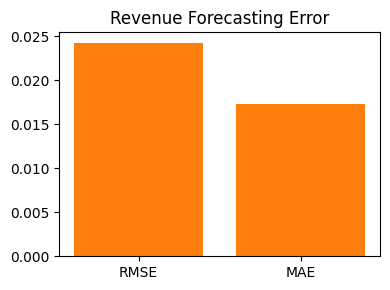

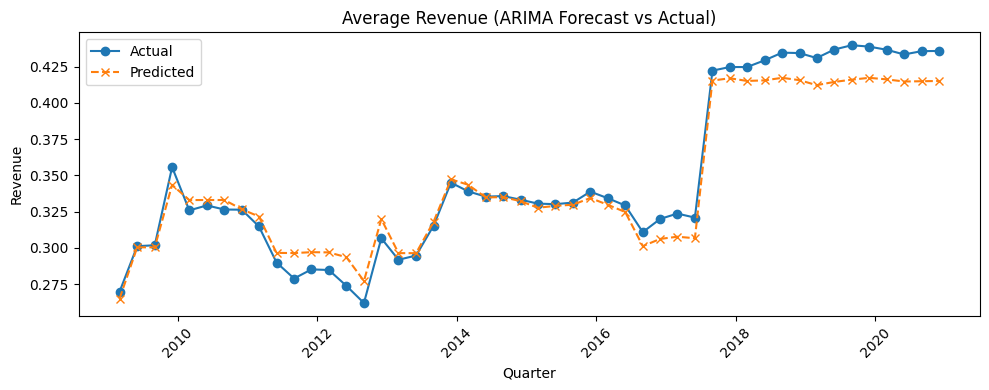

In [7]:
# ===========================
# 7. Visualization
# ===========================
import matplotlib.pyplot as plt

# Revenue error bars
plt.figure(figsize=(4, 3))
plt.bar(['RMSE', 'MAE'], [rmse, mae], color='C1')
plt.title('Revenue Forecasting Error')
plt.tight_layout()
plt.show()

# Revenue time series plot
agg = df_arima_result.groupby('quarter_year')[['y_true_rev', 'y_pred_rev']].mean().reset_index()
agg['quarter'] = pd.to_datetime(
    agg['quarter_year'].str[:4] + '-' +
    (agg['quarter_year'].str[-1:].astype(int) * 3).astype(str) + '-01'
)

plt.figure(figsize=(10, 4))
plt.plot(agg['quarter'], agg['y_true_rev'], label='Actual', marker='o')
plt.plot(agg['quarter'], agg['y_pred_rev'], label='Predicted', marker='x', linestyle='--')
plt.title("Average Revenue (ARIMA Forecast vs Actual)")
plt.xlabel("Quarter")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
# ===========================
# 8. Final Conclusion
# ===========================
from IPython.display import display, Markdown

conclusion_text = '''
# ✅ Final Summary

### 🧮 Revenue Forecast (ARIMA)
- ARIMA(1,1,1) per ticker showed **strong forecasting ability** with:
  - **R² = 0.9791**
  - **RMSE = 0.0242**, **MAE = 0.0173**
- Excellent accuracy for a pure time series model across banks.

### 🧠 CAR Classification (LSTM + BERT Sentiment)
- Model used macroeconomic + FinBERT review sentiment with 3 lags.
- Trained using a **time-based 80/20 split** to avoid leakage.
- Achieved:
  - **ROC-AUC = 0.5107**
  - **PR-AUC = 0.5685**
- Shows modest improvement over baseline; identifies positive CAR patterns well.

### 🧠 Interpretation
- ARIMA is very reliable for revenue trend modeling.
- CAR remains volatile — sentiment improves directional prediction modestly.
- Results are **better than random** and usable for weak signal generation.
- LSTM with BERT sentiment is a good start but needs more tuning and features.
- Future work: add more macroeconomic signals, hybrid models, and ensemble classifiers.

# 📊 Performance Summary

| Target  | Model         | Metric     | Value   |
|:-------:|:-------------:|:----------:|:-------:|
| Revenue | ARIMA(1,1,1)  | RMSE       | 0.0242  |
| Revenue | ARIMA(1,1,1)  | MAE        | 0.0173  |
| Revenue | ARIMA(1,1,1)  | R²         | 0.9791  |
| CAR     | LSTM + BERT   | ROC-AUC    | 0.5107  |
| CAR     | LSTM + BERT   | PR-AUC     | 0.5685  |

'''

display(Markdown(conclusion_text))


# ✅ Final Summary

### 🧮 Revenue Forecast (ARIMA)
- ARIMA(1,1,1) per ticker showed **strong forecasting ability** with:
  - **R² = 0.9791**
  - **RMSE = 0.0242**, **MAE = 0.0173**
- Excellent accuracy for a pure time series model across banks.

### 🧠 CAR Classification (LSTM + BERT Sentiment)
- Model used macroeconomic + FinBERT review sentiment with 3 lags.
- Trained using a **time-based 80/20 split** to avoid leakage.
- Achieved:
  - **ROC-AUC = 0.5107**
  - **PR-AUC = 0.5685**
- Shows modest improvement over baseline; identifies positive CAR patterns well.

### 🧠 Interpretation
- ARIMA is very reliable for revenue trend modeling.
- CAR remains volatile — sentiment improves directional prediction modestly.
- Results are **better than random** and usable for weak signal generation.
- LSTM with BERT sentiment is a good start but needs more tuning and features.
- Future work: add more macroeconomic signals, hybrid models, and ensemble classifiers.

# 📊 Performance Summary

| Target  | Model         | Metric     | Value   |
|:-------:|:-------------:|:----------:|:-------:|
| Revenue | ARIMA(1,1,1)  | RMSE       | 0.0242  |
| Revenue | ARIMA(1,1,1)  | MAE        | 0.0173  |
| Revenue | ARIMA(1,1,1)  | R²         | 0.9791  |
| CAR     | LSTM + BERT   | ROC-AUC    | 0.5107  |
| CAR     | LSTM + BERT   | PR-AUC     | 0.5685  |

